In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
from collections import Counter
from googletrans import Translator
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud
from nltk import pos_tag

data = pd.read_csv('../data/amazon_reviews.csv')

In [10]:
print(data.head())

   Unnamed: 0  score                                             review
0           0      1   Stuning even for the non-gamer: This sound tr...
1           1      1   The best soundtrack ever to anything.: I'm re...
2           2      1   Amazing!: This soundtrack is my favorite musi...
3           3      1   Excellent Soundtrack: I truly like this sound...
4           4      1   Remember, Pull Your Jaw Off The Floor After H...


In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexandra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexandra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\alexandra\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
# Detect language distribution - identifies the language of each review and visualizes
def plot_language_distribution(df, review_column='review'):
    """
    Detects language of each review and plots a frequency chart.
    """
    # Detect language for each review
    df['language'] = df[review_column].apply(lambda x: detect(x) if pd.notnull(x) else 'unknown')

    # Count frequency of each language
    language_counts = df['language'].value_counts()

    # Create bar chart
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=language_counts.index, y=language_counts.values, palette='muted')

    # Add count labels above bars
    for i, value in enumerate(language_counts.values):
        ax.text(i, value + max(language_counts.values)*0.01, str(value),
                ha='center', va='bottom', fontweight='bold')

    plt.title('Language Frequency in Amazon Reviews')
    plt.xlabel('Language Code')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return language_counts

C:\Users\alexandra\AppData\Local\Temp\ipykernel_17548\2331761390.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=language_counts.index, y=language_counts.values, palette='muted')


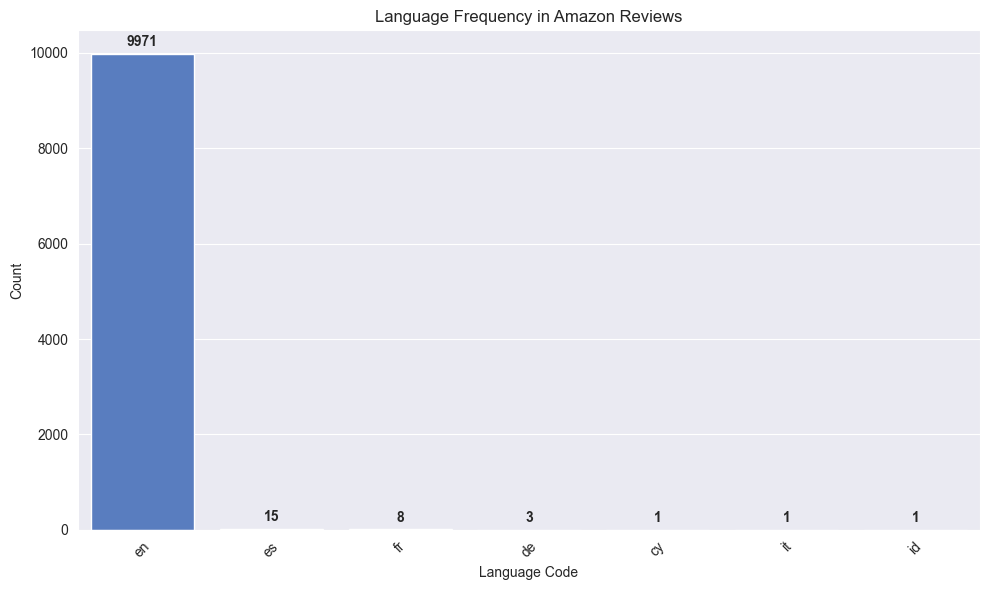

In [5]:
language_distribution_amazon = plot_language_distribution(data)

In [6]:
# Translate non-English reviews to English - ensures all reviews are in the same language
from deep_translator import GoogleTranslator

def detect_and_translate(text):
    """
    Detects language and translates to English if needed.
    Uses deep_translator which is more stable than googletrans.
    """
    try:
        if pd.isnull(text):
            return ""

        lang = detect(text)
        if lang != 'en':
            # Using deep_translator instead
            translator = GoogleTranslator(source=lang, target='en')
            translation = translator.translate(text)
            return translation
        return text
    except Exception as e:
        print(f"Translation error: {e}")
        return text

In [7]:
data['translated_review'] = data['review'].apply(detect_and_translate)

In [8]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alexandra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [9]:
import nltk
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocesses text: lowercase, remove punctuation/numbers, tokenize, remove stopwords.
    """
    if pd.isnull(text):
        return ""

    text = str(text).lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexandra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
data['cleaned_review'] = data['translated_review'].apply(preprocess_text)

In [11]:
print(data.head())

   Unnamed: 0  score                                             review  \
0           0      1   Stuning even for the non-gamer: This sound tr...   
1           1      1   The best soundtrack ever to anything.: I'm re...   
2           2      1   Amazing!: This soundtrack is my favorite musi...   
3           3      1   Excellent Soundtrack: I truly like this sound...   
4           4      1   Remember, Pull Your Jaw Off The Floor After H...   

  language                                  translated_review  \
0       en   Stuning even for the non-gamer: This sound tr...   
1       en   The best soundtrack ever to anything.: I'm re...   
2       en   Amazing!: This soundtrack is my favorite musi...   
3       en   Excellent Soundtrack: I truly like this sound...   
4       en   Remember, Pull Your Jaw Off The Floor After H...   

                                      cleaned_review  
0  stuning even nongamer sound track beautiful pa...  
1  best soundtrack ever anything im reading lot 

In [12]:
# Sentiment analysis - determines if reviews are positive, negative or neutral
def get_sentiment(text):
    """
    Analyzes sentiment of text using TextBlob (-1 to +1 score).
    """
    if pd.isnull(text) or text == "":
        return 0

    blob = TextBlob(text)
    return blob.sentiment.polarity

In [13]:
data['sentiment_score'] = data['cleaned_review'].apply(get_sentiment)
data['sentiment_label'] = data['sentiment_score'].apply(
    lambda score: 'positive' if score > 0 else 'negative' if score < 0 else 'neutral'
)

In [14]:
# Display sentiment distribution
sentiment_counts = data['sentiment_label'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_counts)


Sentiment Distribution:
sentiment_label
positive    7344
negative    2465
neutral      191
Name: count, dtype: int64


In [15]:
neutral_reviews = data[data['sentiment_label'] == 'neutral']
print(f"\nTotal neutral reviews: {len(neutral_reviews)}")


Total neutral reviews: 191


In [16]:
# Extract emotional words and create wordclouds - visualizes key emotional language
def extract_emotional_words(text):
    """
    Extracts emotional words (adjectives and adverbs) from text.
    """
    if pd.isnull(text) or text == "":
        return ""

    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)

    # Only adjectives and adverbs (JJ, JJR, JJS, RB, RBR, RBS)
    emotional_words = [word for word, tag in pos_tags if tag.startswith('JJ') or tag.startswith('RB')]
    return ' '.join(emotional_words)

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordclouds(df, text_column='cleaned_review', sentiment_column='sentiment_label'):
    """
    Creates wordclouds showing emotional words for each sentiment category.
    """
    sentiments = ['positive', 'neutral', 'negative']
    colors = ['Greens', 'Blues', 'Reds']

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    for i, sentiment in enumerate(sentiments):
        subset = df[df[sentiment_column] == sentiment]
        emotional_text = ' '.join(subset[text_column].dropna().apply(extract_emotional_words))

        if emotional_text.strip():  # Only generate if text exists
            wordcloud = WordCloud(width=800, height=400, background_color='white',
                                 colormap=colors[i]).generate(emotional_text)

            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'{sentiment.capitalize()} Reviews (Emotional Language)', fontsize=18)
        else:
            axes[i].text(0.5, 0.5, f"No {sentiment} reviews with emotional words",
                       ha='center', va='center', fontsize=14)

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [18]:
nltk.download('averaged_perceptron_tagger_eng')

# Extract emotional words
data['emotional_words'] = data['cleaned_review'].apply(extract_emotional_words)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\alexandra\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


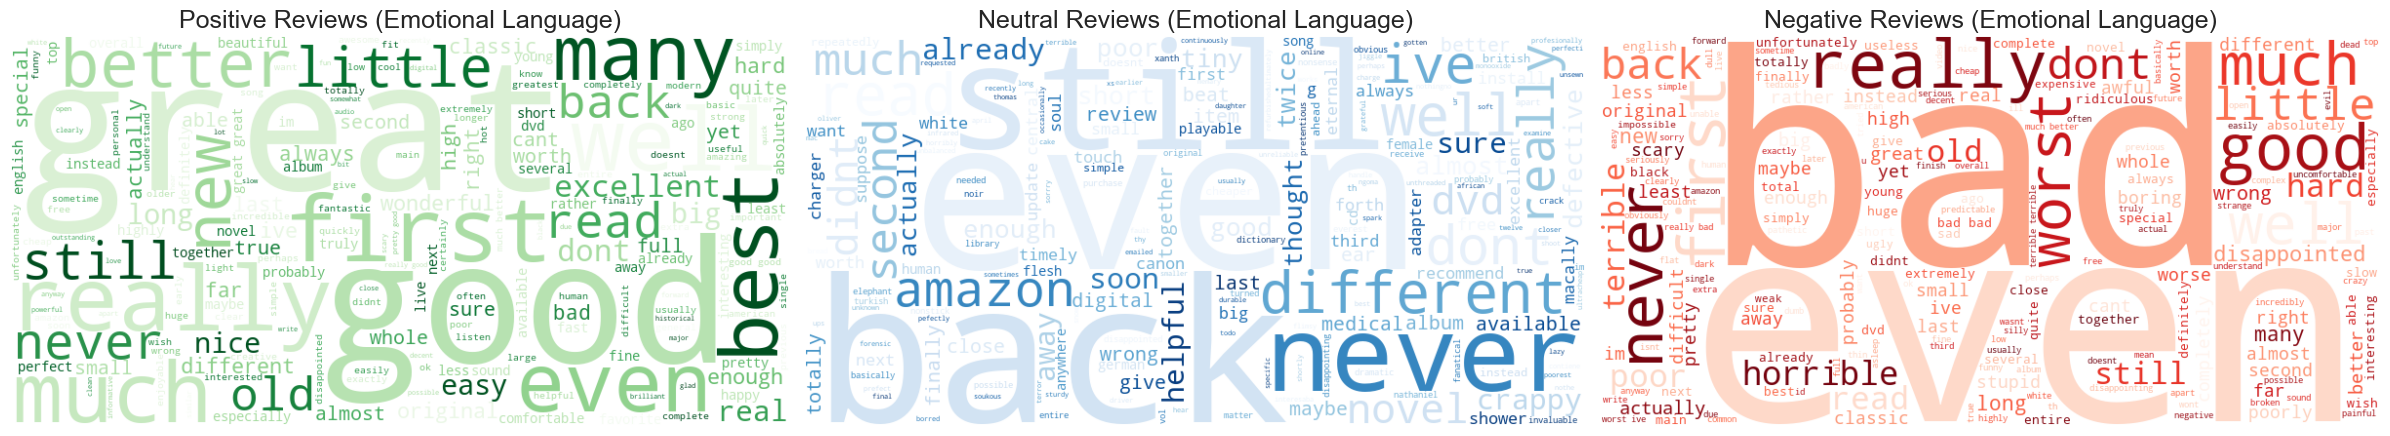

In [19]:
# Create wordclouds
plot_wordclouds(data)

In [20]:
print("Unique values in 'score' column:", sorted(data['score'].unique()))

Unique values in 'score' column: [np.int64(0), np.int64(1)]


In [21]:
# Map the binary score values to sentiment categories
binary_mapping = {
    0: 'negative',
    1: 'positive'
}

# Apply mapping to create original_sentiment column
data['original_sentiment'] = data['score'].map(binary_mapping)

# Create comparison between TextBlob sentiment and original ratings
comparison = pd.crosstab(data['sentiment_label'],
                       data['original_sentiment'],
                       normalize='index')
print("\nComparison between TextBlob sentiment and original ratings:")
print(comparison)

# Optional: Calculate accuracy
if 'original_sentiment' in data.columns and 'sentiment_label' in data.columns:
    # Calculate how often TextBlob sentiment matches original sentiment
    matches = (data['original_sentiment'] == data['sentiment_label']).sum()
    total = len(data)
    accuracy = matches / total
    print(f"\nTextBlob sentiment accuracy: {accuracy:.2%} ({matches} correct out of {total})")


Comparison between TextBlob sentiment and original ratings:
original_sentiment  negative  positive
sentiment_label                       
negative            0.895335  0.104665
neutral             0.696335  0.303665
positive            0.375408  0.624592

TextBlob sentiment accuracy: 67.94% (6794 correct out of 10000)


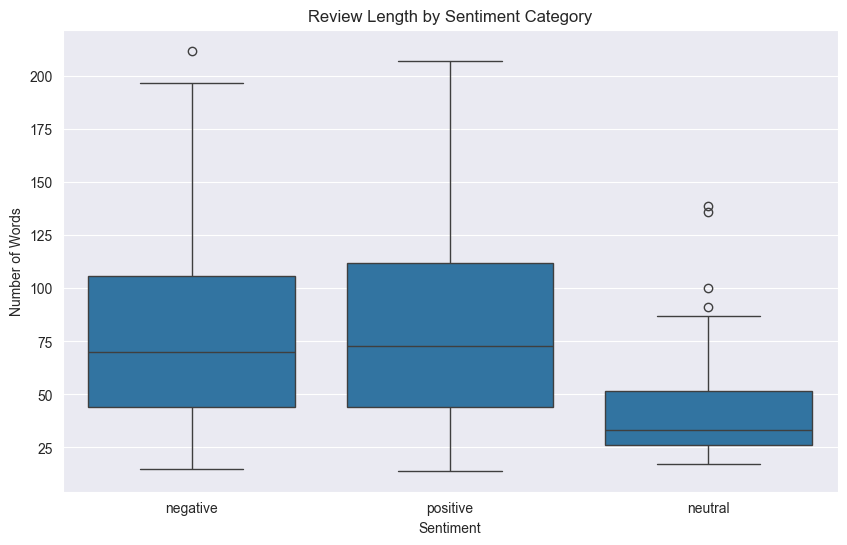

In [22]:
# Distribution of review length by detected sentiment - shows if positive/negative reviews tend to be longer
plt.figure(figsize=(10, 6))
data['review_length'] = data['review'].apply(lambda x: len(str(x).split()))
sns.boxplot(x='sentiment_label', y='review_length', data=data)
plt.title('Review Length by Sentiment Category')
plt.xlabel('Sentiment')
plt.ylabel('Number of Words')
plt.show()

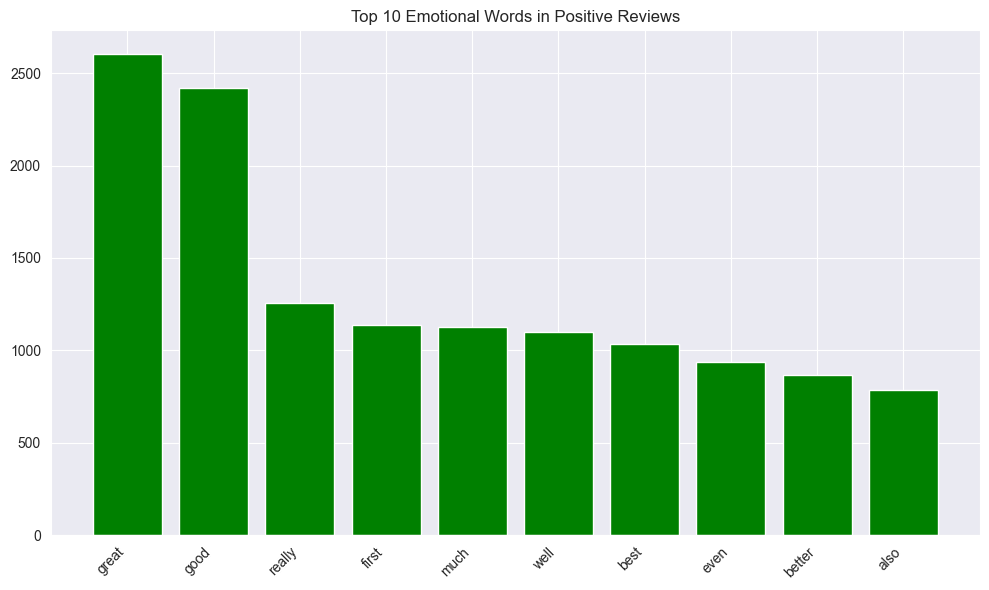

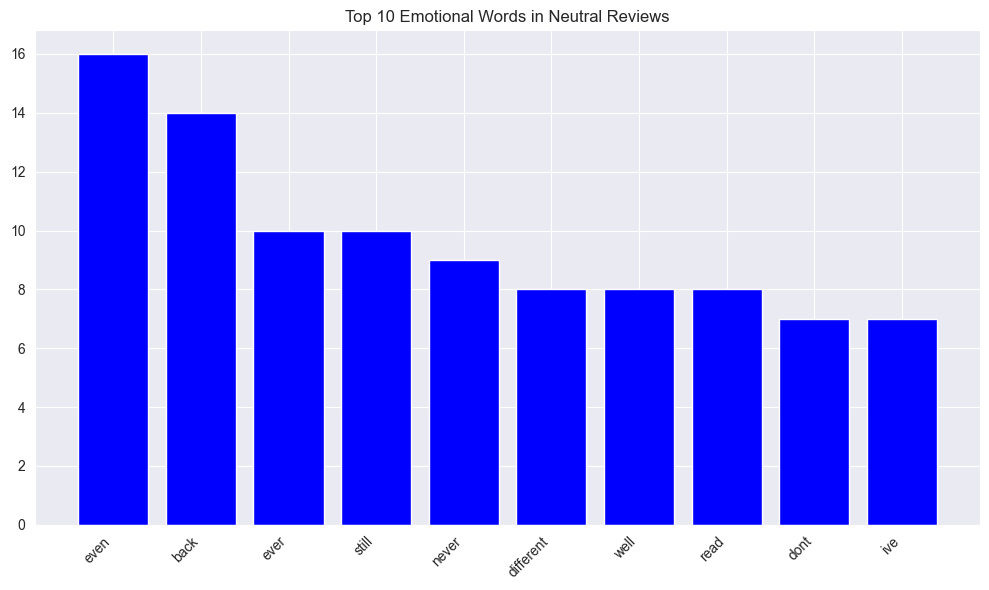

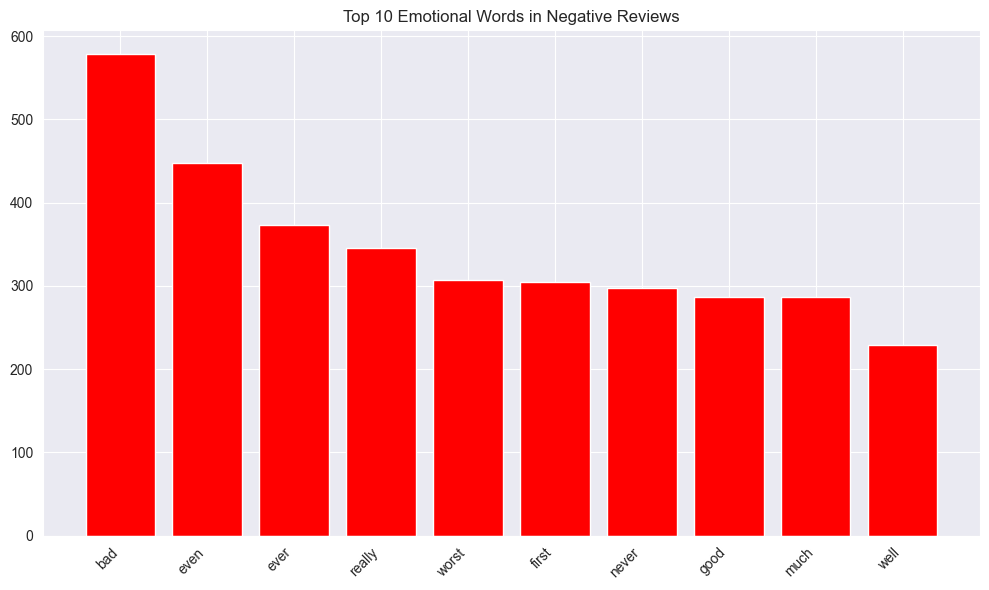

In [38]:
# Most frequent emotional words for each sentiment category - reveals key emotional language
from collections import Counter
import matplotlib.pyplot as plt

def plot_top_words(sentiment_type, n=10):
    # Filter reviews with the specified sentiment
    subset = data[data['sentiment_label'] == sentiment_type]

    # Get all emotional words from this category
    all_words = ' '.join(subset['emotional_words'].dropna()).split()

    # Count word frequency
    word_counts = Counter(all_words)

    # Extract the most frequent n words
    top_words = dict(word_counts.most_common(n))

    # Plot the results
    plt.figure(figsize=(10, 6))
    colors = {'positive': 'green', 'neutral': 'blue', 'negative': 'red'}
    plt.bar(top_words.keys(), top_words.values(), color=colors.get(sentiment_type, 'gray'))
    plt.title(f'Top {n} Emotional Words in {sentiment_type.capitalize()} Reviews')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot for each sentiment category
for sentiment in ['positive', 'neutral', 'negative']:
    if len(data[data['sentiment_label'] == sentiment]) > 0:
        plot_top_words(sentiment)


Class Distribution:
label
1    7344
0    2656
Name: count, dtype: int64
Vectorizing text data...
Features shape: (10000, 5000)
Training set size: 8000, Test set size: 2000

Training Logistic Regression...
Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.93      0.50      0.65       541
           1       0.84      0.99      0.91      1459

    accuracy                           0.85      2000
   macro avg       0.89      0.74      0.78      2000
weighted avg       0.87      0.85      0.84      2000

Logistic Regression ROC AUC: 0.9453

Training Random Forest...
Random Forest Results:
              precision    recall  f1-score   support

           0       0.85      0.59      0.70       541
           1       0.86      0.96      0.91      1459

    accuracy                           0.86      2000
   macro avg       0.86      0.78      0.80      2000
weighted avg       0.86      0.86      0.85      2000

Random Forest ROC AUC: 0.9

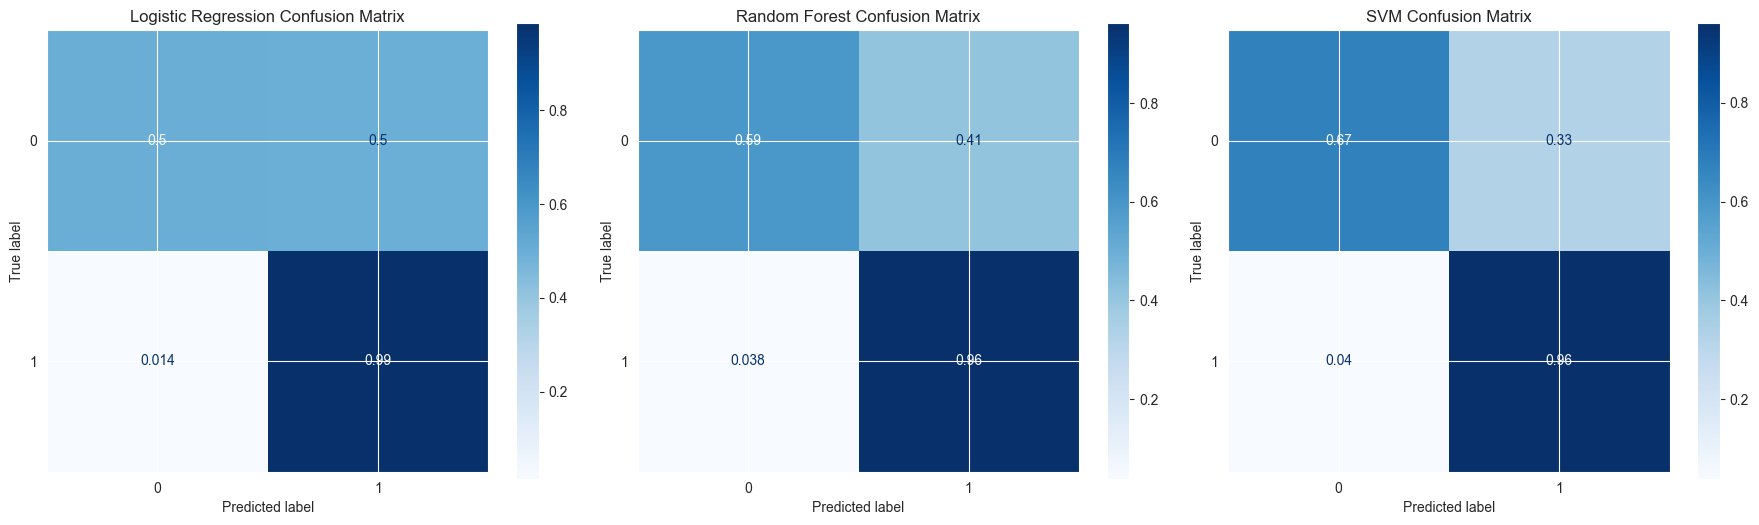

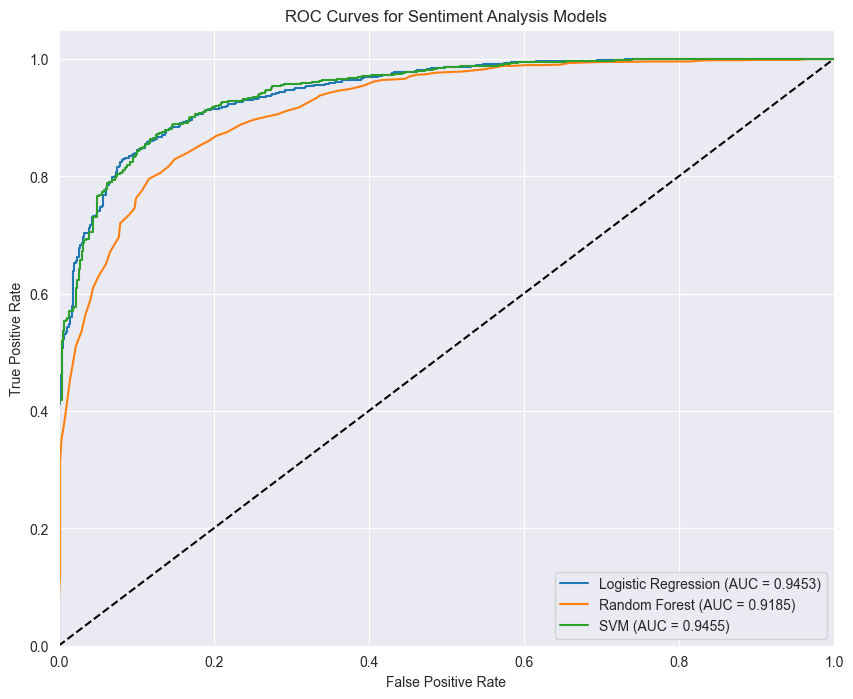

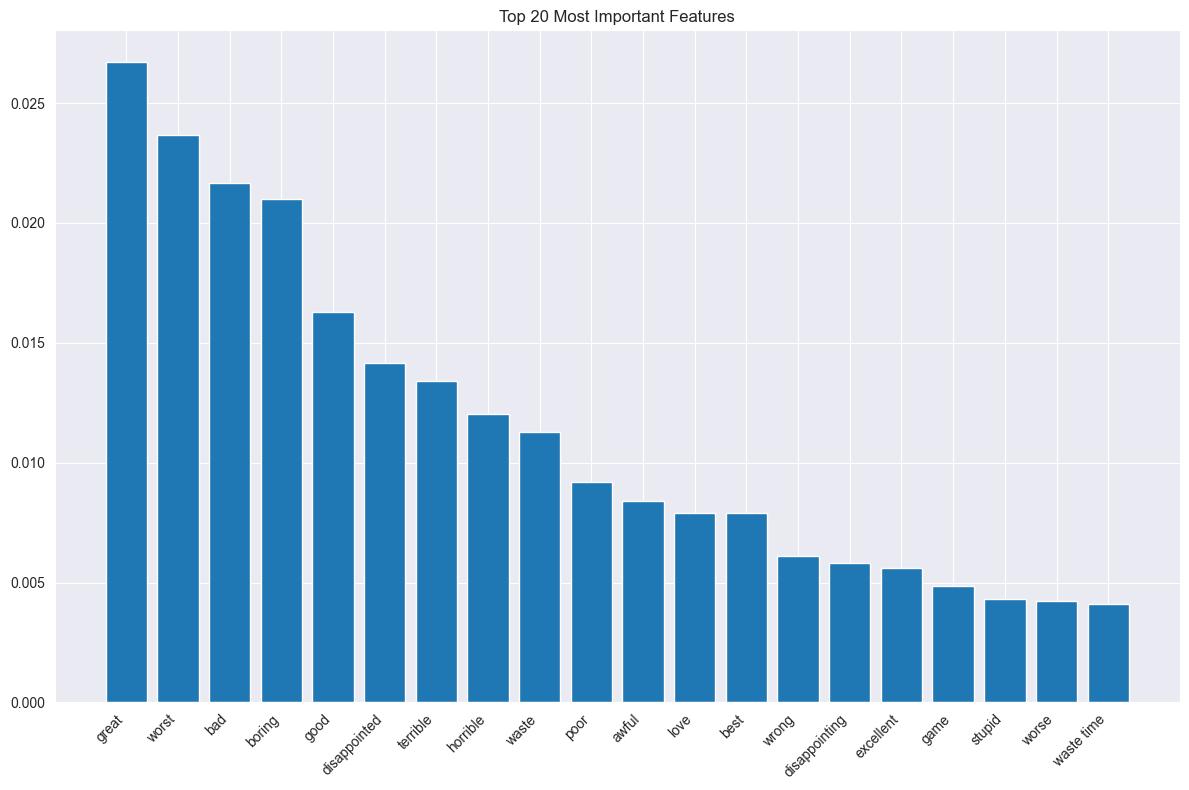


Top 10 important words for sentiment classification:
1. great
2. worst
3. bad
4. boring
5. good
6. disappointed
7. terrible
8. horrible
9. waste
10. poor

Model Comparison Summary:
                 Model  Accuracy   ROC AUC
2                  SVM     0.882  0.945521
0  Logistic Regression     0.855  0.945296
1        Random Forest     0.862  0.918466


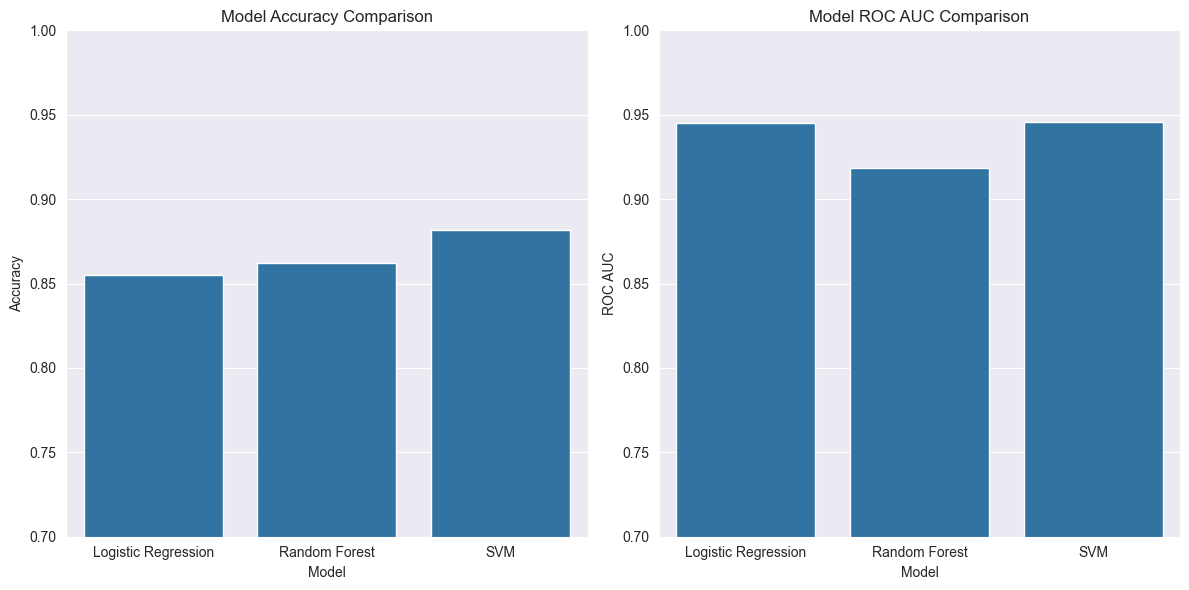

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Let's convert the sentiment labels to numeric values for classification
# Convert sentiment_label to binary classification task (positive vs non-positive)
data['label'] = data['sentiment_label'].apply(lambda x: 1 if x == 'positive' else 0)

# Display class distribution
print("Class Distribution:")
print(data['label'].value_counts())

# Use cleaned_review for features and label for target
X = data['cleaned_review']  # input features
y = data['label']           # target labels (1 for positive, 0 for non-positive)

# TF-IDF Vectorization
print("Vectorizing text data...")
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(X)
print(f"Features shape: {X_tfidf.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

# Model 1: Logistic Regression
print("\nTraining Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_probs = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression Results:")
print(classification_report(y_test, lr_preds))
print(f"Logistic Regression ROC AUC: {roc_auc_score(y_test, lr_probs):.4f}")

# Model 2: Random Forest
print("\nTraining Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

print("Random Forest Results:")
print(classification_report(y_test, rf_preds))
print(f"Random Forest ROC AUC: {roc_auc_score(y_test, rf_probs):.4f}")

# Model 3: Support Vector Machine
print("\nTraining SVM...")
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
svm_probs = svm.predict_proba(X_test)[:, 1]

print("SVM Results:")
print(classification_report(y_test, svm_preds))
print(f"SVM ROC AUC: {roc_auc_score(y_test, svm_probs):.4f}")

# Plot confusion matrices
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, cmap='Blues', normalize='true', ax=ax[0])
ax[0].set_title("Logistic Regression Confusion Matrix")

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='Blues', normalize='true', ax=ax[1])
ax[1].set_title("Random Forest Confusion Matrix")

ConfusionMatrixDisplay.from_estimator(svm, X_test, y_test, cmap='Blues', normalize='true', ax=ax[2])
ax[2].set_title("SVM Confusion Matrix")

plt.tight_layout()
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')

# SVM ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.4f})')

# Add diagonal line
plt.plot([0, 1], [0, 1], 'k--')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Sentiment Analysis Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Feature importance for Random Forest
if hasattr(rf, 'feature_importances_'):
    # Get feature importance from random forest
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Get feature names from TF-IDF vectorizer
    feature_names = np.array(tfidf.get_feature_names_out())

    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    plt.title("Top 20 Most Important Features")
    plt.bar(range(20), importances[indices[:20]], align='center')
    plt.xticks(range(20), feature_names[indices[:20]], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("\nTop 10 important words for sentiment classification:")
    for i in range(10):
        print(f"{i+1}. {feature_names[indices[i]]}")

# Model comparison summary
models = ['Logistic Regression', 'Random Forest', 'SVM']
accuracy = [
    classification_report(y_test, lr_preds, output_dict=True)['accuracy'],
    classification_report(y_test, rf_preds, output_dict=True)['accuracy'],
    classification_report(y_test, svm_preds, output_dict=True)['accuracy']
]
roc_auc = [
    roc_auc_score(y_test, lr_probs),
    roc_auc_score(y_test, rf_probs),
    roc_auc_score(y_test, svm_probs)
]

# Create summary dataframe
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'ROC AUC': roc_auc
})

print("\nModel Comparison Summary:")
print(comparison_df.sort_values('ROC AUC', ascending=False))

# Plot model comparison
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=comparison_df)
plt.title('Model Accuracy Comparison')
plt.ylim(0.7, 1.0)  # Adjusted for better visualization

# Plot ROC AUC
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='ROC AUC', data=comparison_df)
plt.title('Model ROC AUC Comparison')
plt.ylim(0.7, 1.0)  # Adjusted for better visualization

plt.tight_layout()
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import re
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [23]:
# 3-class mapping
def map_sentiment_to_class(sentiment_label):
    if sentiment_label == 'negative':
        return 0
    elif sentiment_label == 'neutral':
        return 1
    else:  # positive
        return 2

In [24]:
# Apply the mapping
data['sentiment_class'] = data['sentiment_label'].apply(map_sentiment_to_class)

In [25]:
# Display the distribution
sentiment_distribution = data['sentiment_class'].value_counts()
print("\nSentiment Class Distribution:")
print(sentiment_distribution)


Sentiment Class Distribution:
sentiment_class
2    7344
0    2465
1     191
Name: count, dtype: int64


In [26]:
def tokenize(text):
    return re.findall(r'\b\w+\b', str(text).lower())

# Build vocabulary from the cleaned reviews
def build_vocab(texts, max_size=25000, min_freq=2):
    counter = Counter()
    for text in texts:
        counter.update(tokenize(text))
    vocab = {'<pad>': 0, '<unk>': 1}
    for word, freq in counter.most_common(max_size):
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

vocab = build_vocab(data['cleaned_review'])
print(f"Vocabulary size: {len(vocab)}")

def numericalize(text, vocab):
    return torch.tensor([vocab.get(token, vocab['<unk>']) for token in tokenize(text)], dtype=torch.long)

Vocabulary size: 16580


In [27]:
# Dataset class
class ReviewDataset(Dataset):
    def __init__(self, dataframe, vocab, text_column='cleaned_review', label_column='sentiment_class'):
        self.texts = dataframe[text_column].tolist()
        self.labels = dataframe[label_column].tolist()
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text_tensor = numericalize(self.texts[idx], self.vocab)
        # For multi-class classification
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return text_tensor, label_tensor

# Collate function for batching
def collate_batch(batch):
    texts, labels = zip(*batch)
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.tensor(labels)
    return padded_texts.to(device), labels.to(device)

# Split the data
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Create datasets and dataloaders
train_dataset = ReviewDataset(train_df, vocab)
valid_dataset = ReviewDataset(valid_df, vocab)
test_dataset = ReviewDataset(test_df, vocab)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)

# Check a batch
for texts, labels in train_loader:
    print(f"Batch shape: {texts.shape}, Labels shape: {labels.shape}")
    print(f"Sample labels: {labels[:5]}")
    break

Batch shape: torch.Size([64, 97]), Labels shape: torch.Size([64])
Sample labels: tensor([0, 2, 2, 2, 0])


In [28]:
# The model architecture - modified for 3 classes
class TextClassificationNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_prob):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                           bidirectional=True, dropout=dropout_prob, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, _) = self.lstm(embedded)
        # Concatenate the final forward and backward hidden states
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        x = self.dropout(F.relu(self.fc1(hidden)))
        return self.fc2(x)  # Output logits for 3 classes

# Model parameters
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 3  # 3 classes: negative, neutral, positive
NUM_LAYERS = 2
DROPOUT_PROB = 0.5

model = TextClassificationNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT_PROB).to(device)
print(model)

TextClassificationNN(
  (embedding): Embedding(16580, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [29]:
# CrossEntropyLoss for multi-class classification
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Multi-class accuracy function
def categorical_accuracy(preds, y):
    max_preds = preds.argmax(dim=1)
    correct = (max_preds == y).float()
    return correct.sum() / len(correct)

def train(model, iterator, optimizer, loss_fn):
    model.train()
    epoch_loss, epoch_acc = 0, 0

    for texts, labels in iterator:
        optimizer.zero_grad()

        # Forward pass
        predictions = model(texts)

        # Calculate loss and accuracy
        loss = loss_fn(predictions, labels)
        acc = categorical_accuracy(predictions, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, loss_fn):
    model.eval()
    epoch_loss, epoch_acc = 0, 0

    with torch.no_grad():
        for texts, labels in iterator:
            predictions = model(texts)
            loss = loss_fn(predictions, labels)
            acc = categorical_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [30]:
# Train the model
N_EPOCHS = 10
best_valid_loss = float('inf')

# Lists to store metrics for plotting
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(N_EPOCHS):
    # Training
    train_loss, train_acc = train(model, train_loader, optimizer, loss_function)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    valid_loss, valid_acc = evaluate(model, valid_loader, loss_function)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    # Print progress
    print(f'Epoch {epoch+1}/{N_EPOCHS}:')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_3class.pt')
        print(f'\t✓ Best model saved! (Valid Loss: {valid_loss:.3f})')

Epoch 1/10:
	Train Loss: 0.613 | Train Acc: 74.57%
	Valid Loss: 0.563 | Valid Acc: 76.44%
	✓ Best model saved! (Valid Loss: 0.563)
Epoch 2/10:
	Train Loss: 0.501 | Train Acc: 79.19%
	Valid Loss: 0.496 | Valid Acc: 78.12%
	✓ Best model saved! (Valid Loss: 0.496)
Epoch 3/10:
	Train Loss: 0.401 | Train Acc: 83.96%
	Valid Loss: 0.485 | Valid Acc: 79.33%
	✓ Best model saved! (Valid Loss: 0.485)
Epoch 4/10:
	Train Loss: 0.330 | Train Acc: 87.17%
	Valid Loss: 0.490 | Valid Acc: 81.49%
Epoch 5/10:
	Train Loss: 0.233 | Train Acc: 91.47%
	Valid Loss: 0.517 | Valid Acc: 81.85%
Epoch 6/10:
	Train Loss: 0.160 | Train Acc: 94.08%
	Valid Loss: 0.526 | Valid Acc: 81.49%
Epoch 7/10:
	Train Loss: 0.120 | Train Acc: 96.29%
	Valid Loss: 0.640 | Valid Acc: 81.13%
Epoch 8/10:
	Train Loss: 0.071 | Train Acc: 97.66%
	Valid Loss: 0.817 | Valid Acc: 79.69%
Epoch 9/10:
	Train Loss: 0.055 | Train Acc: 98.02%
	Valid Loss: 0.847 | Valid Acc: 82.33%
Epoch 10/10:
	Train Loss: 0.026 | Train Acc: 99.23%
	Valid Loss: 0.

Test Loss: 0.491 | Test Acc: 79.59%


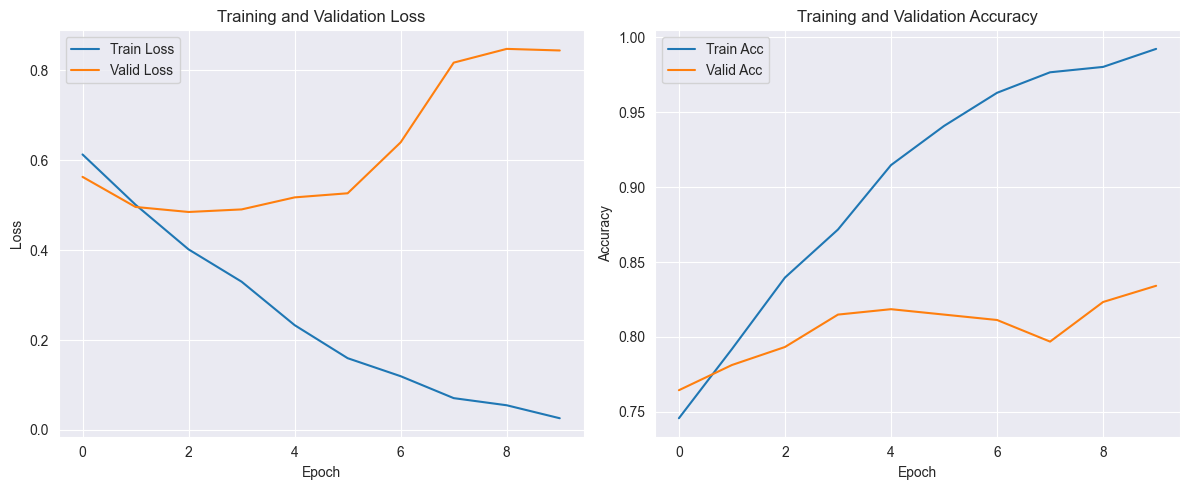

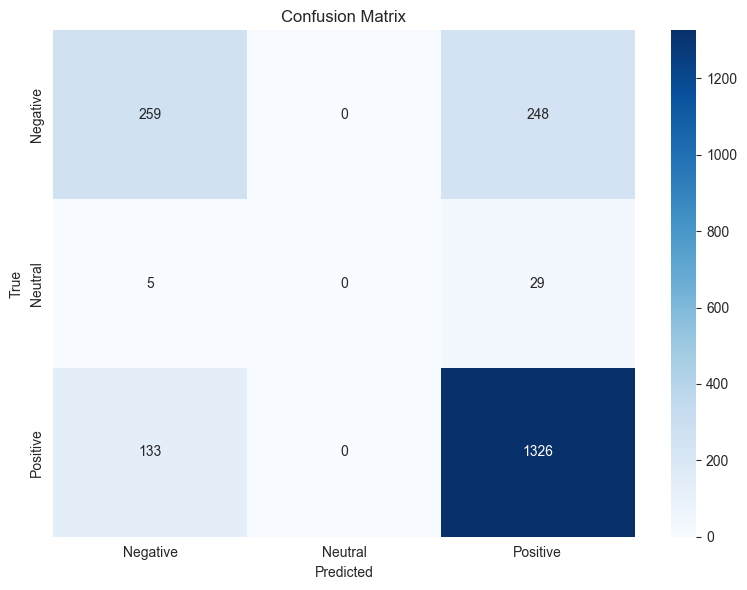

              precision    recall  f1-score   support

    Negative       0.65      0.51      0.57       507
     Neutral       0.00      0.00      0.00        34
    Positive       0.83      0.91      0.87      1459

    accuracy                           0.79      2000
   macro avg       0.49      0.47      0.48      2000
weighted avg       0.77      0.79      0.78      2000



C:\Users\alexandra\PycharmProjects\sentiment-analysis-nlp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alexandra\PycharmProjects\sentiment-analysis-nlp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alexandra\PycharmProjects\sentiment-analysis-nlp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [31]:
# Load the best model
model.load_state_dict(torch.load('best_model_3class.pt'))

# Evaluate on the test set
test_loss, test_acc = evaluate(model, test_loader, loss_function)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(valid_accs, label='Valid Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.tight_layout()
plt.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix(model, test_loader):
    y_pred = []
    y_true = []

    # Get predictions
    model.eval()
    with torch.no_grad():
        for texts, labels in test_loader:
            outputs = model(texts)
            _, predictions = torch.max(outputs, 1)
            y_pred.extend(predictions.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Classification report
    print(classification_report(y_true, y_pred,
                               target_names=['Negative', 'Neutral', 'Positive']))

# Generate confusion matrix
plot_confusion_matrix(model, test_loader)

In [32]:
# Function to predict sentiment for new text
def predict_sentiment(text, model, vocab):
    model.eval()

    # Clean and tokenize the text (using existing preprocessing)
    if hasattr(text, 'lower'):
        cleaned = re.sub(r'[^a-z\s]', '', text.lower())
        tokens = re.findall(r'\b\w+\b', cleaned)
    else:
        tokens = []

    # Convert to tensor
    indexed = [vocab.get(token, vocab['<unk>']) for token in tokens]
    tensor = torch.LongTensor(indexed).unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        prediction = model(tensor)
        probabilities = F.softmax(prediction, dim=1)
        predicted_class = prediction.argmax(1).item()

    # Convert to sentiment label
    sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    result = {
        'sentiment': sentiment_map[predicted_class],
        'probabilities': {
            'negative': probabilities[0][0].item(),
            'neutral': probabilities[0][1].item(),
            'positive': probabilities[0][2].item()
        }
    }

    return result


example_text = "I really enjoyed this product, it exceeded my expectations"
result = predict_sentiment(example_text, model, vocab)
print(f"Text: '{example_text}'")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Probabilities: {result['probabilities']}")

example_text = "It was okay, nothing special but it works"
result = predict_sentiment(example_text, model, vocab)
print(f"Text: '{example_text}'")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Probabilities: {result['probabilities']}")

example_text = "Very disappointed with this purchase, broke after a few days"
result = predict_sentiment(example_text, model, vocab)
print(f"Text: '{example_text}'")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Probabilities: {result['probabilities']}")

Text: 'I really enjoyed this product, it exceeded my expectations'
Predicted sentiment: positive
Probabilities: {'negative': 0.04988135024905205, 'neutral': 0.0009400686249136925, 'positive': 0.9491786360740662}
Text: 'It was okay, nothing special but it works'
Predicted sentiment: positive
Probabilities: {'negative': 0.11292748153209686, 'neutral': 0.0046945977956056595, 'positive': 0.8823779225349426}
Text: 'Very disappointed with this purchase, broke after a few days'
Predicted sentiment: negative
Probabilities: {'negative': 0.7745937705039978, 'neutral': 0.03167114779353142, 'positive': 0.1937350630760193}
